In [ ]:
import os
import numpy as np
from PIL import Image

# Veri seti yolu
data_path ="/content/drive/MyDrive/malaria/cell_images/cell_images"

# Sınıf etiketleri
class_names =  ["Parasitized", "Uninfected"]

# Veri setindeki görüntü sayısı
num_samples = sum([len(files) for r, d, files in os.walk(data_path)])

# Veri seti boyutları
img_height, img_width = 64, 64
num_channels = 3

# X ve y için numpy dizileri
X = np.zeros((num_samples, img_height, img_width, num_channels), dtype=np.float32)
y = np.zeros((num_samples,), dtype=np.int32)

# Verileri yükleyip numpy dizilerine dönüştürme
index = 0
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        X[index] = np.array(img, dtype=np.float32) / 255.
        y[index] = i
        index += 1

# Veri setini karıştırma
np.random.seed(42)
shuffle_index = np.random.permutation(num_samples)
X, y = X[shuffle_index], y[shuffle_index]

# Veri setini train, test ve validation olarak ayırma
num_train_samples = int(0.7 * num_samples)
num_test_samples = int(0.2 * num_samples)
num_val_samples = num_samples - num_train_samples - num_test_samples

x_train, y_train = X[:num_train_samples], y[:num_train_samples]
x_test, y_test = X[num_train_samples:num_train_samples+num_test_samples], y[num_train_samples:num_train_samples+num_test_samples]
x_val, y_val = X[num_train_samples+num_test_samples:], y[num_train_samples+num_test_samples:]

# Dizileri npy dosyalarına kaydetme
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [ ]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [ ]:
# Train verilerinin normalizasyonu
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std

# Test verilerinin normalizasyonu
x_test = (x_test - mean) / std

# Validation verilerinin normalizasyonu
x_val = (x_val - mean) / std


In [ ]:
# Model oluşturma
model = Sequential()

# Convolutional layerlar
model.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train[0].shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# LSTM layer
model.add(Reshape((-1, 128)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())

# Fully connected layerlar
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model eğitimi
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/100
603/603 [==============================] - 21s 12ms/step - loss: 0.2466 - accuracy: 0.9042 - val_loss: 0.1623 - val_accuracy: 0.9507
Epoch 2/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1478 - accuracy: 0.9546 - val_loss: 0.1482 - val_accuracy: 0.9514
Epoch 3/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1363 - accuracy: 0.9560 - val_loss: 0.1329 - val_accuracy: 0.9554
Epoch 4/100
603/603 [==============================] - 7s 11ms/step - loss: 0.1267 - accuracy: 0.9582 - val_loss: 0.1378 - val_accuracy: 0.9576
Epoch 5/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1216 - accuracy: 0.9589 - val_loss: 0.1234 - val_accuracy: 0.9568
Epoch 6/100
603/603 [==============================] - 7s 11ms/step - loss: 0.1135 - accuracy: 0.9616 - val_loss: 0.1217 - val_accuracy: 0.9612
Epoch 7/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1059 - accuracy: 0.9632 - val_loss: 0.1178 - val_accuracy

In [ ]:
# Test verisi üzerinde değerlendirme
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

173/173 [==============================] - 2s 9ms/step - loss: 0.3729 - accuracy: 0.9552
Test loss: 0.37290120124816895
Test accuracy: 0.9551805257797241


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)

[0.9041990637779236, 0.9545878767967224, 0.9560393691062927, 0.9581648707389832, 0.9588906168937683, 0.9615862965583801, 0.9631933569908142, 0.9633488655090332, 0.9668740034103394, 0.9688957929611206, 0.9721099138259888, 0.971643328666687, 0.9766200184822083, 0.9779678583145142, 0.982426106929779, 0.9837221503257751, 0.9863659739494324, 0.9870917797088623, 0.9900984764099121, 0.989061713218689, 0.9918092489242554, 0.9922239780426025, 0.9939865469932556, 0.9933644533157349, 0.9940383434295654, 0.9937273263931274, 0.994971513748169, 0.9923276305198669, 0.9962674975395203, 0.9954898953437805, 0.9965785145759583, 0.9935199618339539, 0.9954380393028259, 0.9954380393028259, 0.994401216506958, 0.9969414472579956, 0.9961638450622559, 0.996734082698822, 0.9967858791351318, 0.9964748620986938, 0.9953861832618713, 0.9974598288536072, 0.9976671934127808, 0.9953343868255615, 0.9983410835266113, 0.9963193535804749, 0.9966303706169128, 0.99704509973526, 0.997356116771698, 0.9976671934127808, 0.995438

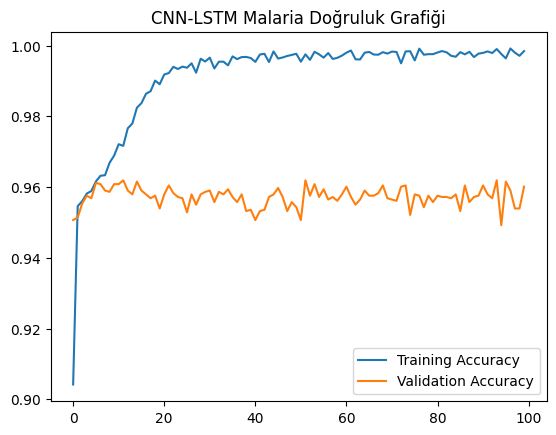

In [ ]:
import matplotlib.pyplot as plt

# Accuracy değerleri
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Eğitim ve doğrulama Accuracy değerlerini grafik olarak çizdirme
plt.title('CNN-LSTM Malaria Doğruluk Grafiği')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

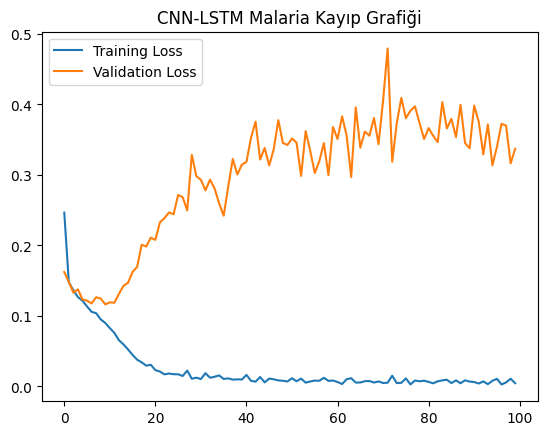

In [ ]:
# Loss değerleri
loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama Loss değerlerini grafik olarak çizdirme
plt.title('CNN-LSTM Malaria Kayıp Grafiği')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test verisi üzerinde tahminlerin oluşturulması
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()

173/173 [==============================] - 1s 4ms/step


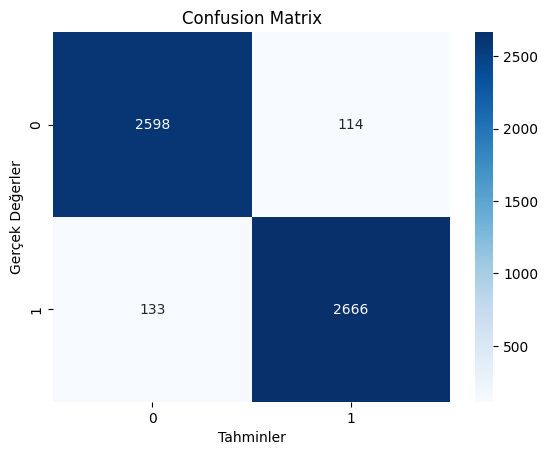

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahminler')
plt.ylabel('Gerçek Değerler')
plt.show()

In [ ]:
# Sınıflandırma raporu
classification_rep = classification_report(y_test, y_pred)
print('Sınıflandırma Raporu:\n', classification_rep)

# Recall, precision ve f1-score değerlerini elde etme
report_lines = classification_rep.split('\n')
for line in report_lines[2:-5]:
    line_data = line.split()
    if len(line_data) >= 4:
        class_label = int(line_data[0])
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1 = float(line_data[3])
        print('Sınıf:', class_label)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1-score:', f1)
        print('----------------------')

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      2712
           1       0.96      0.95      0.96      2799

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511

Sınıf: 0
Precision: 0.95
Recall: 0.96
F1-score: 0.95
----------------------
Sınıf: 1
Precision: 0.96
Recall: 0.95
F1-score: 0.96
----------------------


In [ ]:
# Test verileri üzerinde sınıf olasılıklarını elde etme
y_pred_probs = model.predict(x_test)

173/173 [==============================] - 1s 5ms/step


Mikro-Ortalama AUC Skoru: 0.9867116996061595
Makro-Ortalama AUC Skoru: 0.9869254427150025


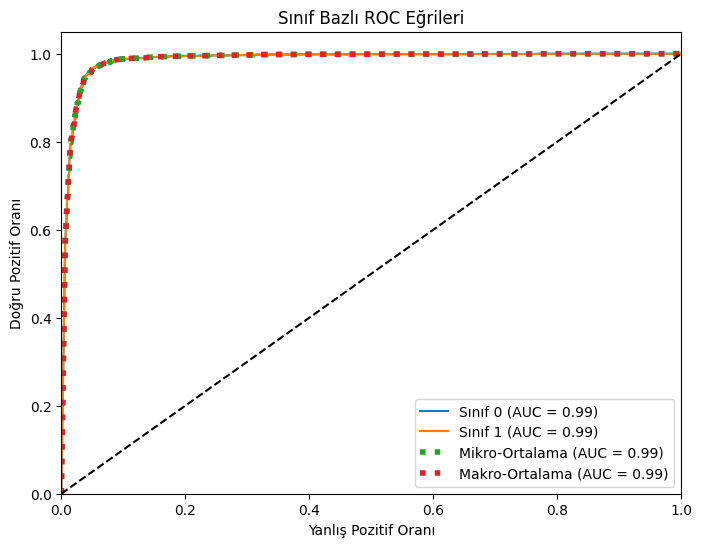

In [ ]:
# ROC eğrisi ve AUC skoru hesaplama
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Mikro-ortalamalı ROC eğrisi ve AUC skoru hesaplama
fpr_micro, tpr_micro, _ = roc_curve(y_test, y_pred_probs)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Makro-ortalamalı ROC eğrisi ve AUC skoru hesaplama
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 2
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Sonuçları yazdırma
print('Mikro-Ortalama AUC Skoru:', roc_auc_micro)
print('Makro-Ortalama AUC Skoru:', roc_auc_macro)

# ROC eğrilerini çizme
plt.figure(figsize=(8, 6))
for i in range(2):  # Sınıf sayısı 2 olduğunu varsayalım
    plt.plot(fpr[i], tpr[i], label='Sınıf %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Mikro-ortalamalı ROC eğrisini çizme
plt.plot(fpr_micro, tpr_micro, label='Mikro-Ortalama (AUC = %0.2f)' % roc_auc_micro, linestyle=':', linewidth=4)

# Makro-ortalamalı ROC eğrisini çizme
plt.plot(fpr_macro, tpr_macro, label='Makro-Ortalama (AUC = %0.2f)' % roc_auc_macro, linestyle=':', linewidth=4)

# Rastgele tahmin edilen ROC eğrisini çizme
plt.plot([0, 1], [0, 1], 'k--')

# Eksen ve başlık ayarları
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Sınıf Bazlı ROC Eğrileri')
plt.legend(loc="lower right")

# Grafik gösterme
plt.show()
